# PSF photometry on artificial Gaussian stars

In [1]:
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import models, fitting

In [2]:
from photutils import psf

In [3]:
%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get "real" images
rcParams['figure.figsize'] = (15,10)

## First make a fake image with trivial gaussian PSFs 

In [4]:
gmod = models.Gaussian2D(x_stddev=2.5, y_stddev=2.5)

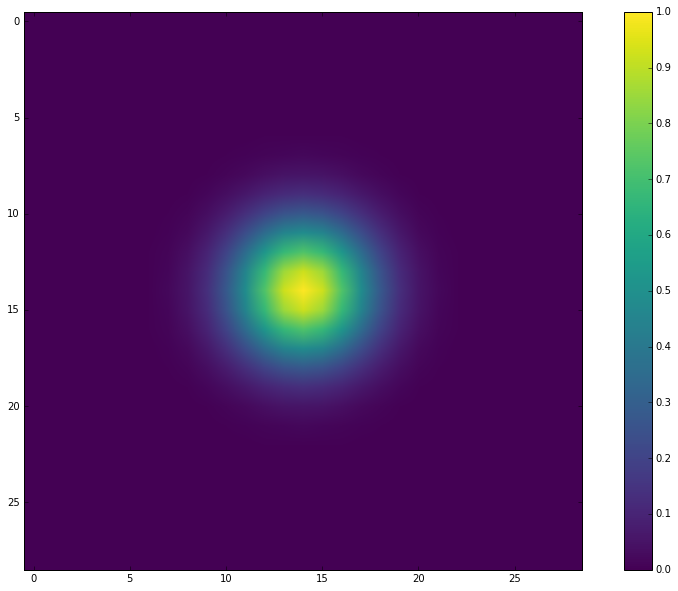

In [5]:
#uses bounding box
plt.imshow(gmod.render(), vmin=0, vmax=1)
plt.colorbar()

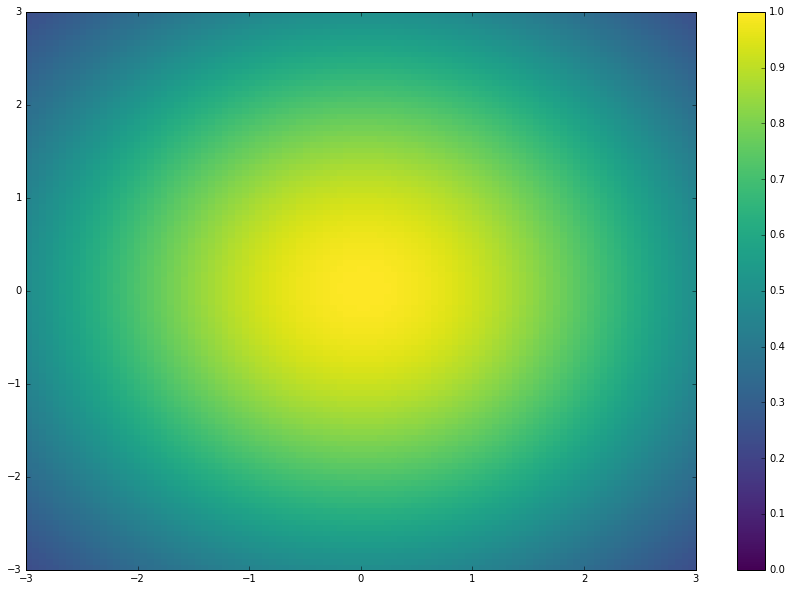

In [6]:
gmod2 = gmod.copy()
gmod2.bounding_box = None
coo = np.mgrid[-3:3:100j, -3:3:100j]

plt.pcolor(coo[0], coo[1], gmod2.render(coords=coo), vmin=0, vmax=1)
plt.colorbar()

## Now create an image that's just got a few PSF stars

In [7]:
nstars = 15
poisson_scale = 15
bkg = 1
flux_scale = 2500


im = np.ones((512,512))*bkg

np.random.seed(123456789)

xs, ys = np.random.rand(2, nstars)*512
fluxes = (np.random.rand(nstars)+.5)*flux_scale

(0.13333333333333333, 5.9633042715280213, 7.0666666666666664)


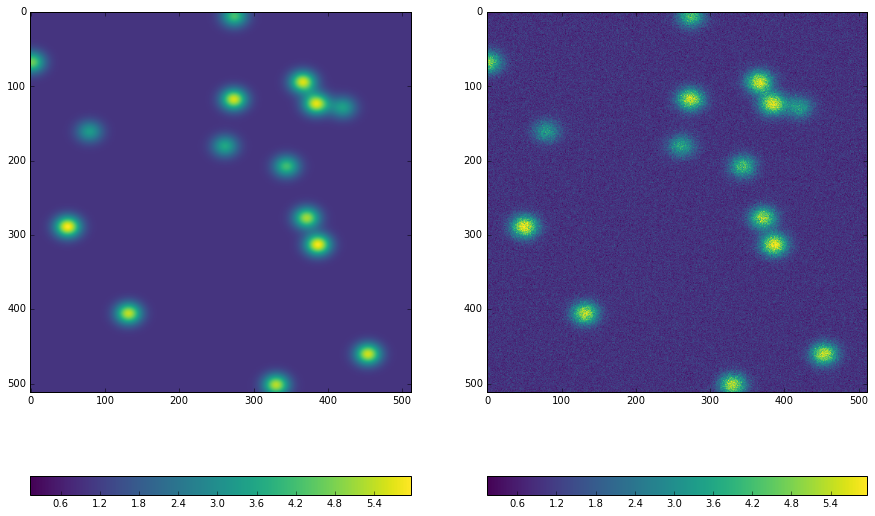

In [8]:
gmod_star = models.Gaussian2D(x_stddev=12, y_stddev=10)
round_sigma = (gmod_star.x_stddev*gmod_star.y_stddev)**0.5


intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

for row in intab:
    del gmod_star.bounding_box  # resets the bounding box to the default
    gmod_star.x_mean = row['x_0']
    gmod_star.y_mean = row['y_0']
    gmod_star.amplitude = row['flux_0']/(2*np.pi*gmod_star.x_stddev*gmod_star.y_stddev)
    gmod_star.render(im)
    
pim = np.random.poisson(poisson_scale*im)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(im, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(pim, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')

print(np.min(pim), np.max(im), np.max(pim))

(0.066666666666666666, 5.9633042715280213, 12.6)


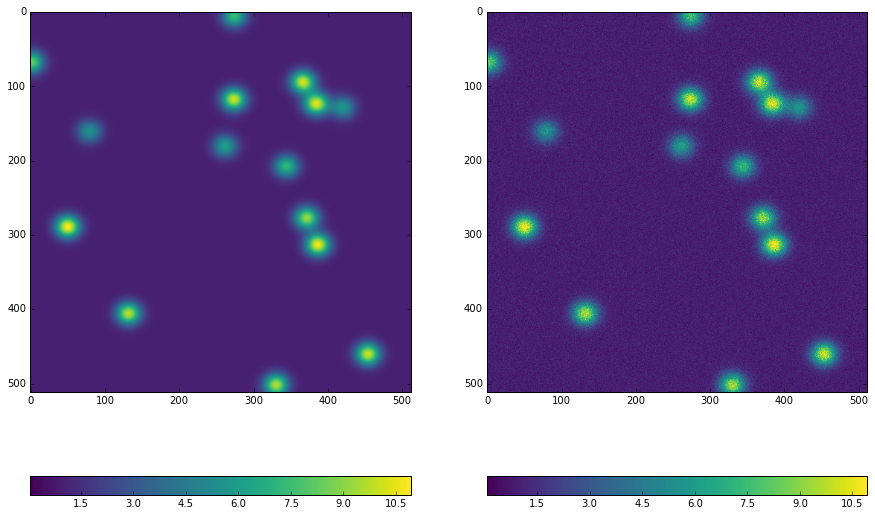

In [9]:
gmodi_star = psf.IntegratedGaussianPRF(sigma=round_sigma)

intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

imi = im.copy()

for row in intab:
    del gmodi_star.bounding_box  # resets the bounding box to the default
    gmodi_star.x_0 = row['x_0']
    gmodi_star.y_0 = row['y_0']
    gmodi_star.flux = row['flux_0']
    gmodi_star.render(imi)
    
pimi = np.random.poisson(poisson_scale*imi)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(imi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(pimi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')

print(np.min(pimi), np.max(im), np.max(pimi))

In [10]:
def residuals_psf_sub_table(outtab, title=None):
    plt.subplot(3,1,1)
    if title is not None:
        plt.title(title)
    plt.scatter(np.arange(len(outtab))+1, (outtab['flux_fit']-outtab['flux_0'])*100./outtab['flux_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('fluxperc')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,2)
    plt.scatter(np.arange(len(outtab))+1, outtab['x_fit']-outtab['x_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dx')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,3)
    plt.scatter(np.arange(len(outtab))+1, outtab['y_fit']-outtab['y_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dy')
    plt.xlim(0.5, len(outtab)+.5)
    
    plt.tight_layout()

In [11]:
# note that this assumes the underlying image is the same as the above
def compare_psf_sub(subim, pim, im, kw1s={}, kw2s={}, kw3s={}, kw4s={}):
    subps = [2, 2, 0]
    cborient = 'vertical'
    
    subps[-1] +=1
    plt.subplot(*subps)
    plt.imshow(pim, **kw1s)
    plt.colorbar(orientation=cborient)
    plt.title('Base image')
    
    subps[-1] +=1
    plt.subplot(*subps)
    plt.imshow(subim, **kw2s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF subtracted image')
    print("Subtracted image bkg-sub mean:", np.mean(subim-bkg), 'and SD:', np.std(subim-bkg))

    subps[-1] +=1
    plt.subplot(*subps)
    plt.imshow(im, **kw3s)
    plt.colorbar(orientation=cborient)
    plt.title('Real noise-free images')

    subps[-1] +=1
    plt.subplot(*subps)
    plt.imshow(pim-subim, **kw4s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF images')

## Now do the actual PSF fitting and subtraction

In [12]:
psf_guess = psf.IntegratedGaussianPRF(flux=1, sigma=round_sigma)
psf_guess.flux.fixed = psf_guess.x_0.fixed = psf_guess.y_0.fixed = False
psf_guess.x_0.sigma = True

### Start with perfect inputs 

Assuming you know the flux and locations perfectly, how well can you subtract?

('Subtracted image bkg-sub mean:', 0.15923809486221835, 'and SD:', 0.63666359444169063)


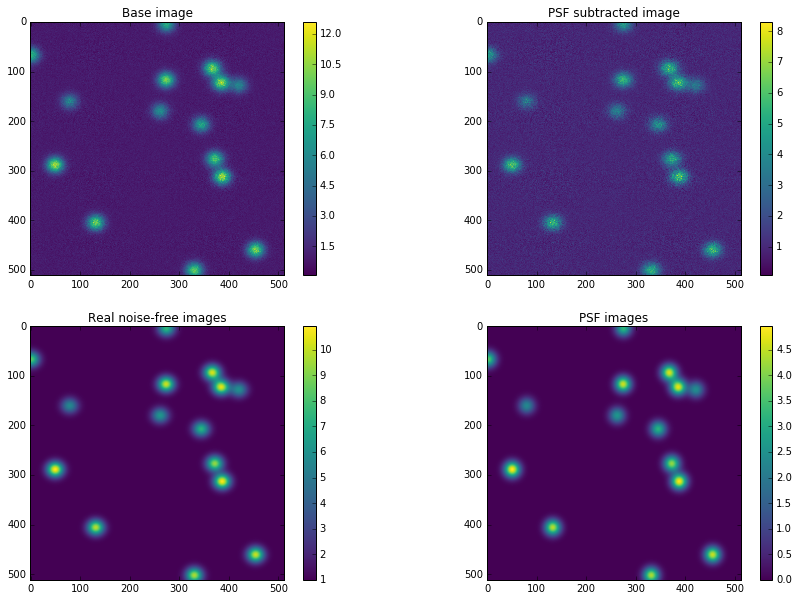

In [13]:
subimi = psf.subtract_psf(pimi, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subimi, pimi, imi)

Now what about when the PSF doesn't quite match? (The image was generated with a slightly elliptical PSF)

('Subtracted image bkg-sub mean:', 3.4757215933320872e-06, 'and SD:', 0.28294181437421773)


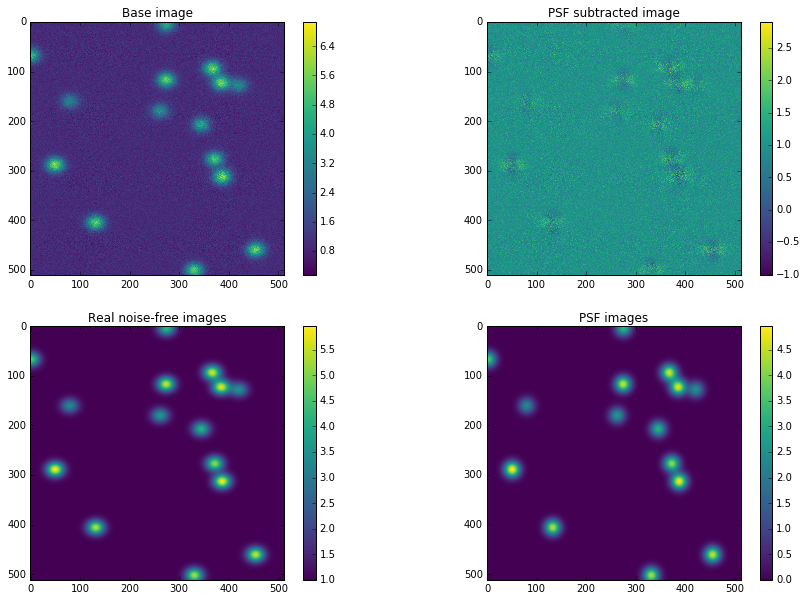

In [14]:
subim = psf.subtract_psf(pim, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subim, pim, im)

In [15]:
# fitting region used by all the below 
fitshape = (8,8)

## Now try actually *fitting* the target stars

### Perfect info on location/flux

Start with perfect initial gluesses for the flux and location, starting with a perfect PSF model 

In [16]:
# with integrated psf
outtabi = psf.psf_photometry(pimi - bkg, intab, psf_guess, fitshape)
outtabi.show_in_notebook()

('Subtracted image bkg-sub mean:', -0.0020784962440081193, 'and SD:', 0.30824838701045421)


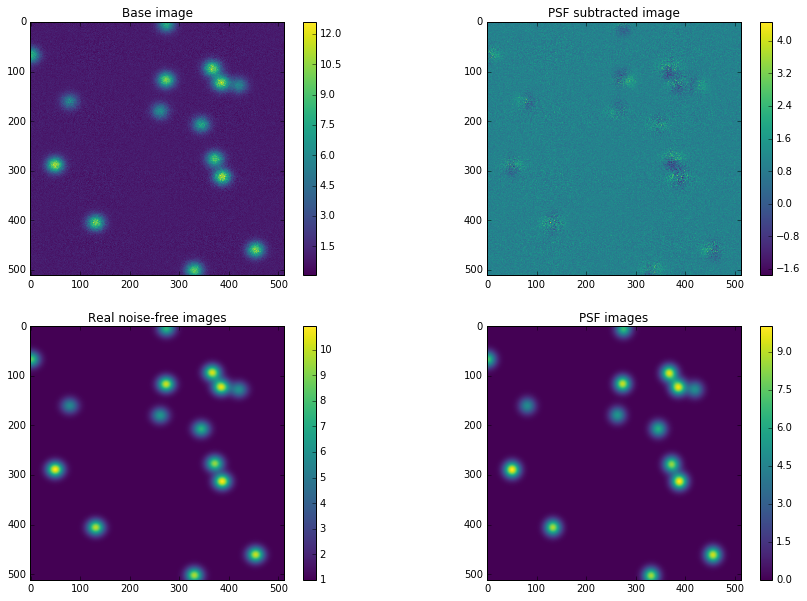

In [17]:
subimi = psf.subtract_psf(pimi, psf_guess, outtabi)
compare_psf_sub(subimi, pimi, imi)

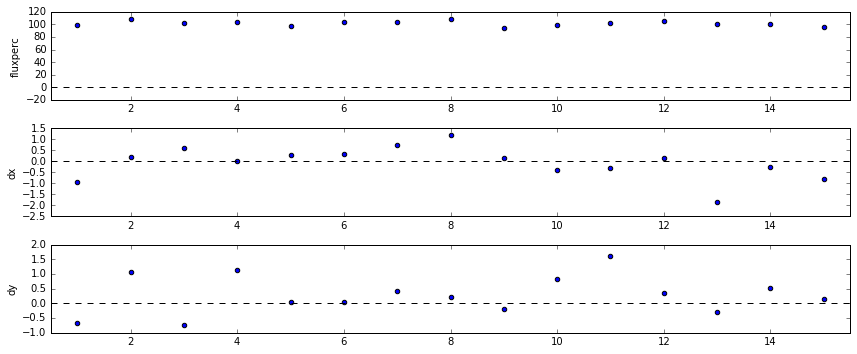

In [18]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And now with a slightly-wrong model (round model, elliptical PSF)

In [19]:
outtab = psf.psf_photometry(pim - bkg, intab, psf_guess, fitshape)
outtab.show_in_notebook()

('Subtracted image bkg-sub mean:', -0.0011038600035506827, 'and SD:', 0.28752729648684699)


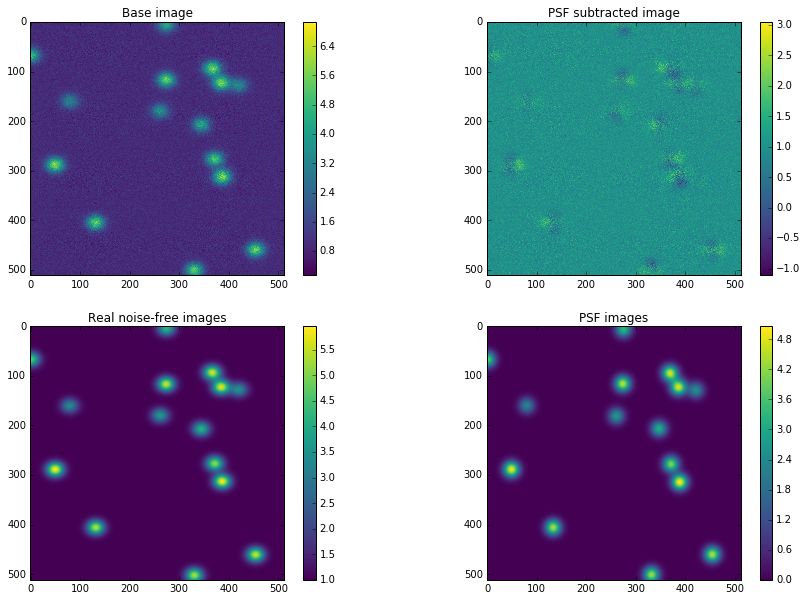

In [20]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

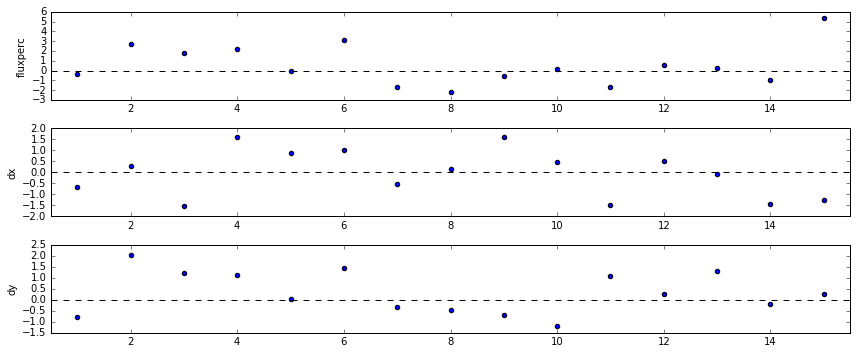

In [21]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)

### Perfect input location, but incorrect flux guess

In [22]:
intab2 = intab['x_0', 'y_0']

As before, start with a well-matched model and PSF

In [23]:
outtabi = psf.psf_photometry(pimi - bkg, intab2, psf_guess, fitshape, store_fit_info=True)
outtabi['flux_0'] = intab['flux_0']
outtabi.show_in_notebook()

('Subtracted image bkg-sub mean:', 0.15813075913707433, 'and SD:', 0.63764377165256036)


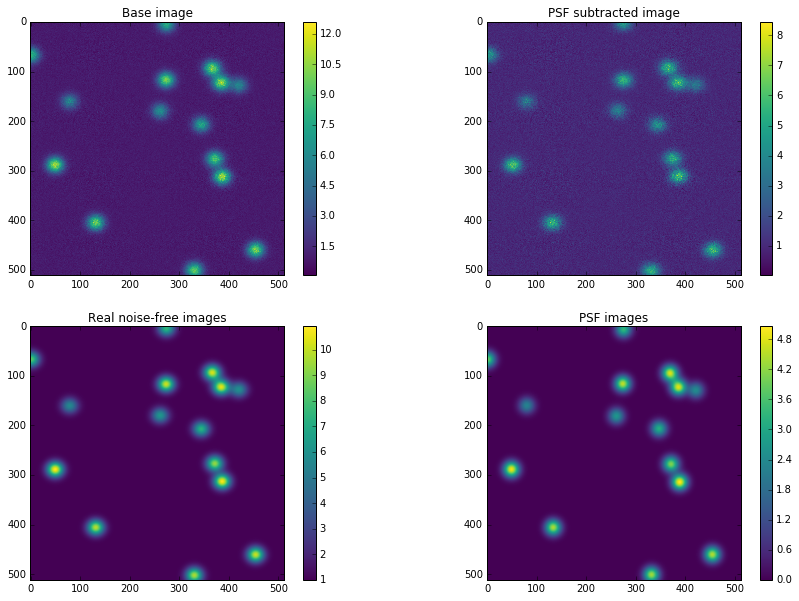

In [24]:
subimi = psf.subtract_psf(pimi, psf_guess, outtab)
compare_psf_sub(subimi, pimi, imi)

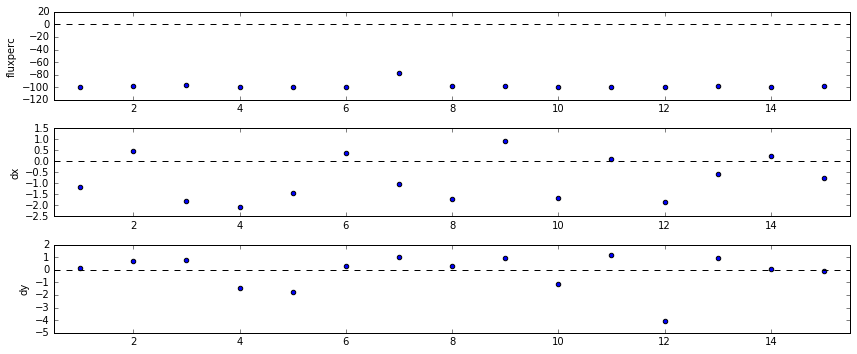

In [25]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And try again with slightly wrong PSF model

In [26]:
outtab = psf.psf_photometry(pim - bkg, intab2, psf_guess, fitshape, store_fit_info=True)
outtab['flux_0'] = intab['flux_0']
outtab.show_in_notebook()

('Subtracted image bkg-sub mean:', 0.15325410484853677, 'and SD:', 0.61075376574108486)


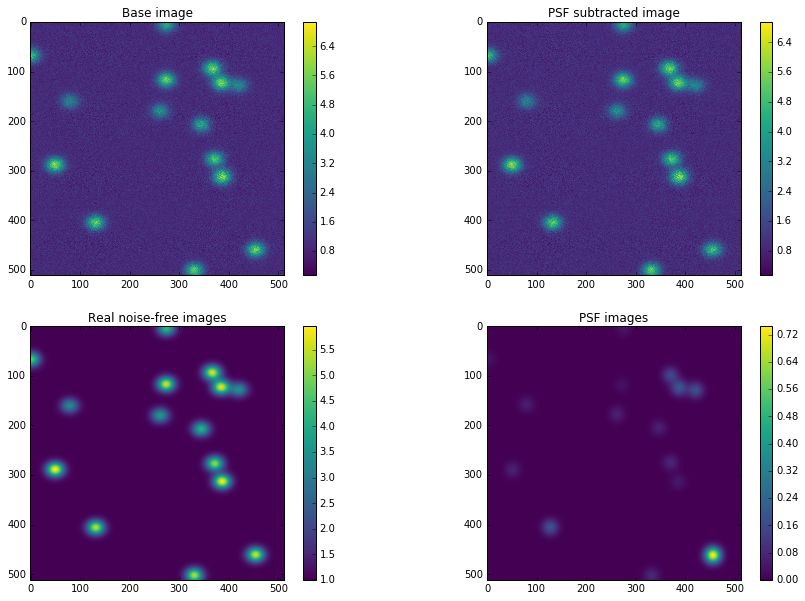

In [27]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

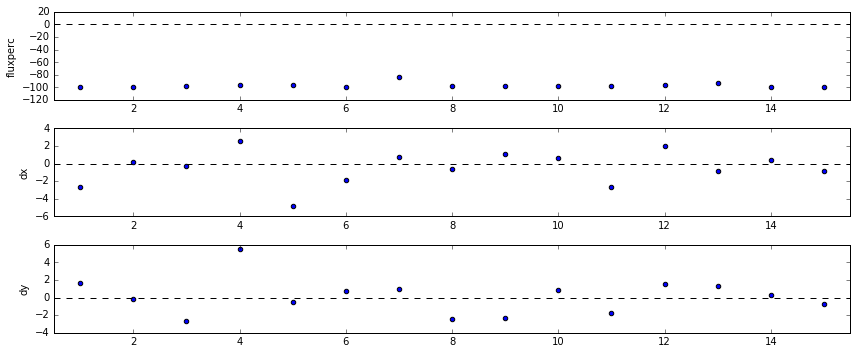

In [28]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)

### Now try with a mocked star-finder that's good but not perfect at the few percent level

In [29]:
x_finder = xs + np.random.randn(*xs.shape)*.1
y_finder = ys + np.random.randn(*ys.shape)*.1
finder_flux = fluxes + np.random.randn(*fluxes.shape)*fluxes/25

# percent error in the flux guesses
(finder_flux-fluxes)*100/fluxes

array([ 1.84850647,  1.30834844,  1.11514986, -0.57084775,  2.07486286,
        0.19275915,  2.49461457,  2.93517056,  4.55597082, -1.70088561,
       -6.37016271,  1.21137041, -0.95336414,  1.45065474, -2.67135082])

In [30]:
intab3 = Table(names=['x_0', 'y_0', 'flux_0'], data=[x_finder, y_finder, finder_flux])

Again, we start with the matched PSF model

In [31]:
outtabi = psf.psf_photometry(pimi - bkg, intab3, psf_guess, fitshape, store_fit_info=True)
outtabi['flux_input'] = intab3['flux_0']
outtabi['flux_0'] = intab['flux_0']
outtabi.show_in_notebook()

('Subtracted image bkg-sub mean:', 0.31248872398916183, 'and SD:', 1.1446351458956237)


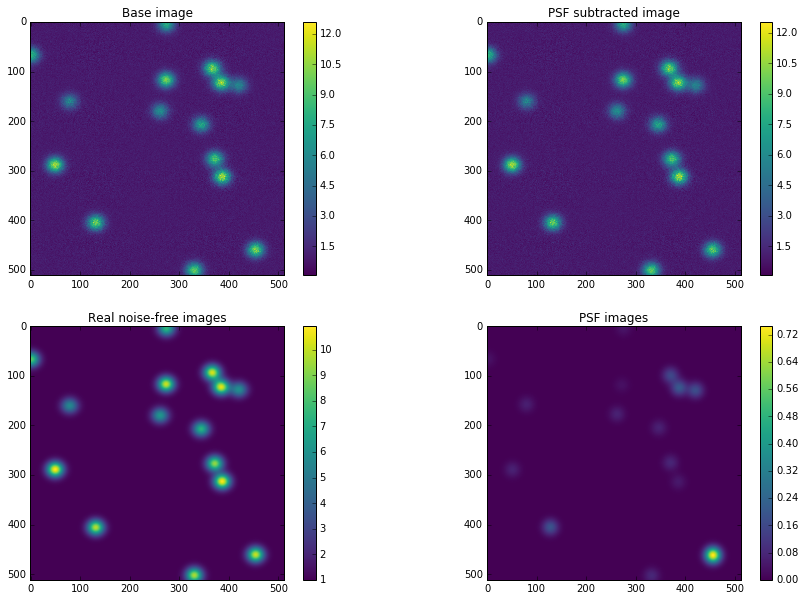

In [32]:
subimi = psf.subtract_psf(pimi, psf_guess, outtab)
compare_psf_sub(subimi, pimi, imi)

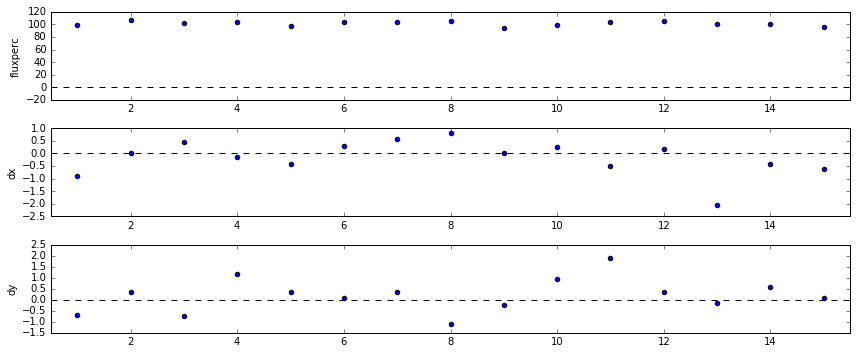

In [33]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And then try again with the mis-matched set

In [34]:
outtab = psf.psf_photometry(pim - bkg, intab3, psf_guess, fitshape, store_fit_info=True)
outtab['flux_input'] = intab3['flux_0']
outtab['flux_0'] = intab['flux_0']
outtab.show_in_notebook()

('Subtracted image bkg-sub mean:', -0.001270783162556022, 'and SD:', 0.28787712596089149)


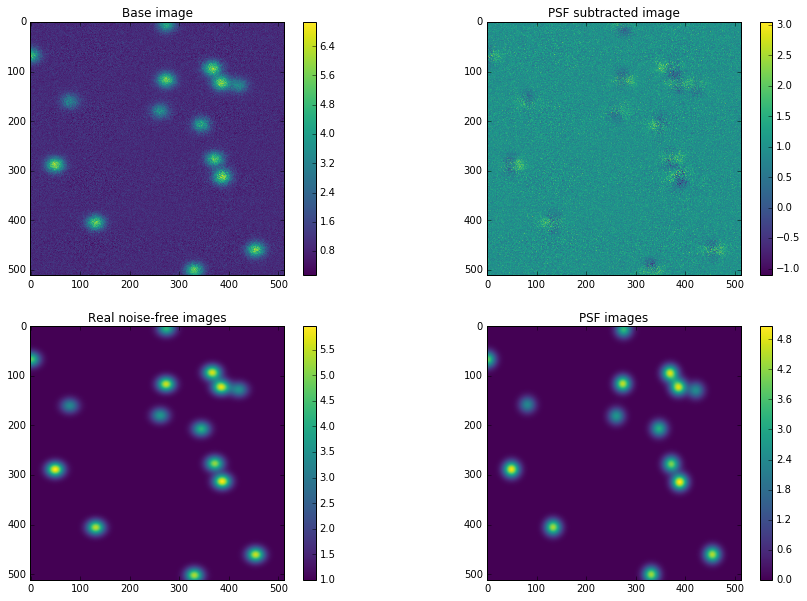

In [35]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

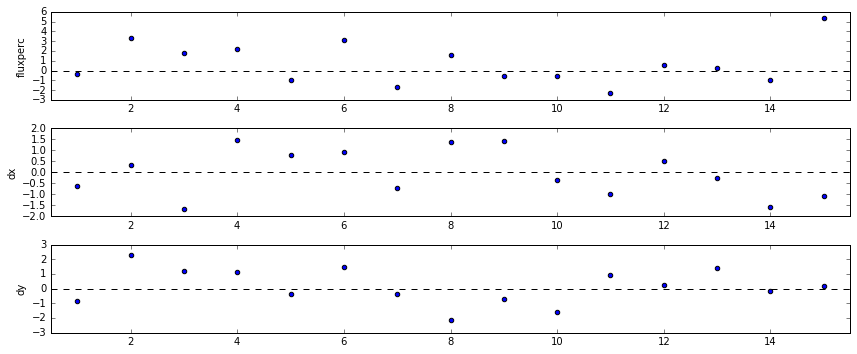

In [36]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)